Demo of the reference point selection algorithm (Part 1) and applying the reference point for InSAR SBAS (Part 2) according to Zhang et al. 2024

Part 1 shows each of the five steps of the algorithm and plot intermediate results
Part 2 uses the reference point to estimate water level time series.

Details refer to Zhang, B., Hestir, E., Yunjun, Z., Reiter, M.E., Viers, J.H., Schaffer-Smith, D., Sesser, K. and Oliver-Cabrera, T., 2024. Automated Reference Points Selection for InSAR Time Series Analysis on Segmented Wetlands. IEEE Geoscience and Remote Sensing Letters.

In [16]:
%matplotlib widget

import os
import h5py
import numpy as np
from mintpy.objects import ifgramStack
from mintpy.utils import readfile
from mintpy.utils import utils as ut
from mintpy.utils import network as pnet, ptime, readfile, utils0 as ut0
from mintpy.objects import timeseries
from mintpy.utils import arg_utils
from mintpy.cli import timeseries2velocity
from mintpy.defaults.template import get_template_content
from mintpy.cli import tsview
from scipy.io import loadmat
import scipy.io as sio
import geopandas as gpd
import pyproj 
import math
from pyproj import Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import itertools
import shapefile as shp
from shapely.geometry import Point
from shapely.geometry import shape 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from skimage import measure, morphology as morph, segmentation as seg

Set up the threshold parameters 

Note that at the end, we set wetland unit (wu) as 4. Meaning this demo focuses on this wetland unit, the same as Unit 3 in Zhang et al. 2024

In [3]:
refthd = 0.90
thdpt = 0.95
radius = 1000
tops = radius * radius  ## Select the top 30 reference points for each wetland pixel 
normct_thd = 0.8
wetthd = 30 ## minimum percentage of connection from one wetland pixel to the radius*radius window 
pxpercomp = 5 ## how many pixel selected from each component
paththd = 0.9

cc20 = 'exclude'
cc200 = '200cc'
cclevel = 0
conn = 6
min_area = 30
bicoh_min_area = 2
dilation = 2

conn = 6
trgoi = range(9, 19 + 1) ## SacP1Ac1
#trgoi = range(8, 18 + 1) ## ClsT15c3 May 5 to Sep 3
nd = trgoi ## the index for SAR acquisitions
ndi = range(trgoi[0] * conn, trgoi[-1] * conn + 1) ## the index for interferograms
print("Original index for interferograms of interest were: {ndi}".format(ndi = ndi))
ndi = [x for x in ndi if x % conn == 0 or x % conn == 1]

wu = 4

Original index for interferograms of interest were: range(54, 115)


defining functions used for the rest of the notebook

In [44]:
def label_conn_comp(mask, min_area, erosion_size=5, print_msg=False):
    """Label / clean up the conn comp (mask)
    Parameters: mask         - 2D np.ndarray of bool/int
                min_area     - float, minimum region/area size
                erosion_size - int (odd number), size of erosion structure
                               set to 0 to turn it off.
    Returns:    label_img    - 2d np.ndarray of int, labeled array where all
                               connected regions are assigned the same value
                num_label    - int, number of labeled regions
    """

    # label
    label_img, num_label = measure.label(mask, connectivity=1, return_num=True)

    ## remove small regions
    min_area = min(min_area, label_img.size * 3e-3)
    if print_msg:
        print(f'remove regions with area < {int(min_area)}')
    mask = morph.remove_small_objects(label_img, min_size=min_area, connectivity=1)
    label_img[mask == 0] = 0
    # update label
    label_img, num_label = measure.label(label_img, connectivity=1, return_num=True) # re-label

    ## remove regions that would disappear after erosion
    # to ensure the consistency between label_img and label_bound
    if erosion_size > 0:
        erosion_structure = np.ones((erosion_size, erosion_size))
        label_erosion_img = a.erosion(label_img, erosion_structure).astype(np.uint8)

        erosion_regions = measure.regionprops(label_erosion_img)
        if len(erosion_regions) < num_label:
            if print_msg:
                print('regions lost during morphological erosion operation:')

            label_erosion = [reg.label for reg in erosion_regions]
            for orig_reg in measure.regionprops(label_img):
                if orig_reg.label not in label_erosion:
                    label_img[label_img == orig_reg.label] = 0
                    if print_msg:
                        print('label: {}, area: {}, bbox: {}'.format(orig_reg.label,
                                                                     orig_reg.area,
                                                                     orig_reg.bbox))

            # update label
            label_img, num_label = measure.label(label_img, connectivity=1, return_num=True)

    return label_img, num_label

def eulid_dist(xt, yt, xo, yo):
    return np.sqrt((xt - xo) * (xt - xo) + (yt - yo) * (yt - yo))

def close_point(latbt, lonbt):
    dist = 1000
    for i in range(xrg * yrg):   ## calculate the closest sar pixel 
        temp = eulid_dist(latbt, lonbt, lat_1d[i], lon_1d[i])
        if (temp < dist):
            dist = temp
            indexbt = i
    xbt = indexbt % xrg
    ybt = (indexbt - xbt) / xrg
    ybt = int(ybt)
    xbt = int(xbt)
    return indexbt, ybt, xbt
    
def close_point_wet(latbt, lonbt, wu):
    dist = 1000
    wbest = -999
    for i in range(wetnum):
        temp = eulid_dist(latbt, lonbt, lalo[i][0], lalo[i][1])
        if (temp < dist):
            dist = temp
            wbest = i
    return wbest ## index in the wetland

def wgs2utm(lat, lon):
    lat_rad = lat * (np.pi / 180)
    lon_rad = lon * (np.pi / 180)
    a = 6378137  # Semi-major axis of the WGS84 ellipsoid
    f = 1 / 298.257223563  # Flattening of the WGS84 ellipsoid
    k0 = 0.9996
    e_squared = 2 * f - f * f
    N = a / sqrt(1 - e_squared * sin(lat_rad)**2)
    T = np.tan(lat_rad)**2
    C = e_squared / (1 - e_squared) * cos(lat_rad)**2
    lon0 = -81 * (np.pi / 180)  # Central meridian for UTM Zone 17 North in radians
    A = (lon_rad - lon0) * cos(lat_rad)
    M = a * (
       (1 - e_squared / 4 - 3 * e_squared**2 / 64 - 5 * e_squared**3 / 256) * lat_rad -
       (3 * e_squared / 8 + 3 * e_squared**2 / 32 + 45 * e_squared**3 / 1024) * sin(2 * lat_rad) +
       (15 * e_squared**2 / 256 + 45 * e_squared**3 / 1024) * sin(4 * lat_rad) -
       (35 * e_squared**3 / 3072) * sin(6 * lat_rad))
    x = k0 * N * (A + (1 - T + C) * A**3 / 6 + (5 - 18 * T + T**2 + 72 * C - 58 * e_squared) * A**5 / 120)
    y = k0 * (M + N * np.tan(lat_rad) * (A**2 / 2 + (5 - T + 9 * C + 4 * C**2) * A**4 / 24 + (61 - 58 * T + T**2 + 600 * C - 330 * e_squared) * A**6 / 720))
    x_utm = x + 500000  # False easting for UTM
    y_utm = y   # False northing for Northern hemisphere
    return x_utm/30, y_utm/30 ## convert to pixel 

def calculate_distance(pixel1, pixel2):
    avg_value1 = sum(pixel1) / len(pixel1)
    avg_value2 = sum(pixel2) / len(pixel2)
    return abs(avg_value1 - avg_value2)



def binary_image(input_image, threshold):
    # Apply the threshold
    binary_image = (input_image > threshold).astype(np.uint8)

    return binary_image


 
def dilate_nb(x, y, size, img):
    startx = int(x - size)
    starty = int(y + size)
    for i in range(size * 2):
        for j in range(size * 2):
            img[starty - i, startx + j] = 1 ## y first, then x 
    return img  

def calculate_rmse(actual_values, predicted_values):
    mse = np.mean((actual_values - predicted_values) ** 2)
    rmse = np.sqrt(mse)
    return rmse

Setting up path to ifgramStack.h5, geometryGeo.h5, and shapefile

Note: Change Path and shpfile according to your own directory

In [5]:
Path = '/Users/boyazhang/Documents/Work/California/Processing/SacFull'
ifgram_stack = Path + '/inputs/ifgramStack.h5'
geom_file = Path  + '/inputs/geometryGeo.h5' 
inc = Path + '/SacFull.csv'


shpfile = '/Users/boyazhang/Documents/Work/California/Shapefile/Sac/Project_sac.shp'
temp = readfile.read(ifgram_stack, datasetName='coherence', box=(0, 0, 1, 1))[0]
stack_obj = ifgramStack(ifgram_stack)                    
coh = stack_obj.read(datasetName='coherence') ## connections, y, x
xrg = coh.shape[2]
yrg = coh.shape[1]
k   = coh.shape[0]
conncomp = stack_obj.read(datasetName='connectComponent')


reading coherence data from file: /Users/boyazhang/Documents/Work/California/Processing/SacFull/inputs/ifgramStack.h5 ...
reading connectComponent data from file: /Users/boyazhang/Documents/Work/California/Processing/SacFull/inputs/ifgramStack.h5 ...


Step 1 Classify pixels into wetland and non-wetland pixels. 

Variable inclusion is a 1-d array with value 0 representing non-wetlands, other integer values (1 - 10) are indices of wetlands of interest.

Note that we only focus on wetlands: 0, 2, 4, 7, 8, 9, (with indices 1, 3, 5, 8, 9, 10) correspnding to the six units used in Zhang et al. 2024 because these wetlands have a valid DEM models for us to test the reference point selection algorithm. 

This step takes ~4-5 minutes 

In [6]:
################ Step 1 Classifying pixels for AOI and non-AOI pixels############
sf = shp.Reader(shpfile) 
sfRec = sf.records()
all_shapes = sf.shapes()
all_records = sf.records() 
feature = sf.shapeRecords()[0]
first = feature.shape.__geo_interface__

meta = readfile.read_attribute(ifgram_stack)
coord_obj = ut.coordinate(meta, geom_file)
lat_stack_all = np.zeros((yrg, xrg))
lon_stack_all = np.zeros((yrg, xrg))
lat_1d = np.zeros((xrg * yrg))
lon_1d = np.zeros((xrg * yrg))
inclusion = np.zeros((xrg * yrg))


############################# Calculate value for each pixel in the AOI ############################
ct = 0
for i in range(yrg):
    print(i)
    for j in range(xrg):
        lat, lon = coord_obj.radar2geo(i, j)[0:2]
        lat_stack_all[i, j] = lat
        lon_stack_all[i, j] = lon
        lat_1d[ct] = lat
        lon_1d[ct] = lon
        ct = ct + 1
        
ct = 0
for i in range(yrg):
    print(i)
    for j in range(xrg): 
        point_to_check = (lon_stack_all[i, j], lat_stack_all[i, j])
        for t in range(10):
            boundary = all_shapes[t] # get a boundary polygon
            if Point(point_to_check).within(shape(boundary)): # make a point and see if it's in the polygon
                inclusion[ct] = t + 1
                break;
      
        ct = ct + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Step 2 - calculating for each pixel the percentage of InSAR pairs with an coherence greater than the threshoold coh_thd. If this percentage is greater than threshold thdpt, and the pixel is located outside of any wetlands, it is marked as a qualifed reference candidate (variable quality)

coh_2d is the mean coherence map across temporal domain

In [7]:
refthd = 0.90
paththd = 0.9

krt = len(ndi) ## important - change the temporal length

xrg = coh.shape[2]
yrg = coh.shape[1]
k   = coh.shape[0]

print(xrg)
print(yrg)

conn_2d = np.zeros((krt, xrg * yrg))
pt1d = np.zeros(xrg * yrg)
pt2d = np.zeros((yrg, xrg))
cohfilt = coh[ndi, :, :]
connfilt = conncomp[ndi, :, :]

quality = np.zeros((yrg, xrg))
coh_1d = np.zeros((xrg * yrg))
coh_2d = np.zeros((xrg, yrg))

ct = 0

for i in range(yrg):
    print(i)
    for j in range(xrg):
        conn_2d[:, ct] = connfilt[:, i, j]
        coh_1d[ct] = np.mean(cohfilt[:, i, j]) ## recording the mean value of coh in time. 
        temp = cohfilt[:, i, j]
        pt = len(np.where(temp > refthd)[0]) / krt
        pt1d[ct] = pt
        pt2d[i, j] = pt
        if ((pt > thdpt) & (inclusion[ct] == 0)):
            quality[i, j] = 1
        if(inclusion[ct] > 0): # wetland pixel
            pt1d[ct] = 0
            pt2d[i, j] = 0
        ct = ct + 1
        

coh_2d = np.mean(cohfilt, axis=0) ## average coherence value



259
367
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

Visualize the intermediate results from Step 2. 
It should be the same as Fig. 3a in Zhang et al. 2024

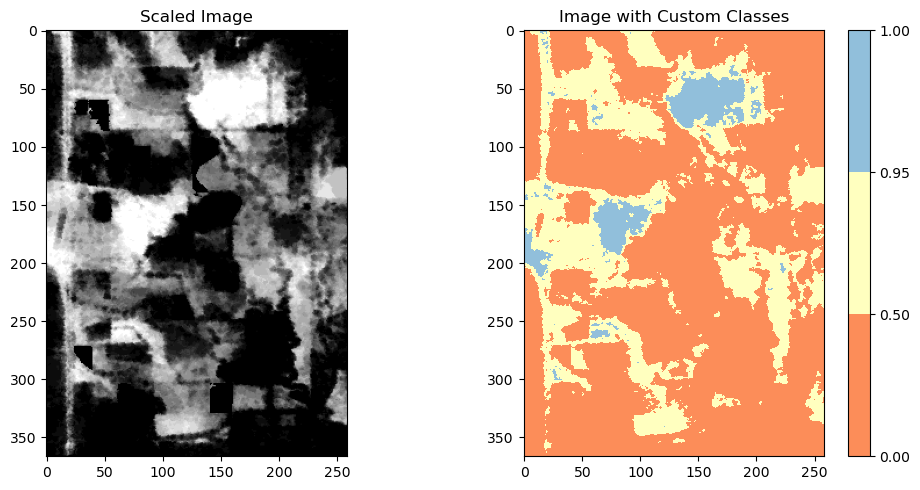

In [8]:
#################  Visualize the results of Step 2 ###############
%matplotlib inline

class_ranges = [0, 0.5, 0.95, 1]
colors = ['#fc8d59', '#ffffbf', '#91bfdb']
norm = BoundaryNorm(class_ranges, len(class_ranges)-1)
# Create colormap
cmap = ListedColormap(colors)

# Scale the matrix to the range 0 to 255
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scale the matrix to the range 0 to 255
scaled = (pt2d * 255).astype(np.uint8)

# Plot the scaled image on the first subplot
axes[0].imshow(scaled, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Scaled Image')  # Set title

# Plot data on the second subplot
im2 = axes[1].imshow(pt2d, cmap=cmap, norm=norm)
axes[1].set_title('Image with Custom Classes')  # Set title

# Add color bar for reference to the second subplot
cbar = fig.colorbar(im2, ax=axes[1])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



Step 3 - for each wetland pixel, searching for nearby reference candidates resulting from Step 2, and calculate the percentage of InSAR pairs that connected to the wetland pixel.

This step results in two important variables: normct and targ, both are 2-d array. Each one with the size of (number of wetland pixels, size of the searching square)

normct is the normalized connnections in percentage (0 - 1)
targ is the pixel index for the reference candidates

This step takes about ~5 minutes

In [9]:
label = connfilt
wetnum = len(np.where(inclusion == wu + 1)[0])
count = np.zeros((wetnum, radius * radius)) ## the frequency of the connected in time domain
targ = np.zeros((wetnum, radius * radius)) ## the index of the target pixel
normct = np.zeros((wetnum, radius * radius)) ## normalized the top list
lalo = np.zeros((wetnum, 2))
print('Starting calculating the frequency and reference point')
wetind = 0 ## used a index for recording the wetland pixels. 
for i in range(yrg):
    print(i)
    for j in range(xrg):
        
        ind = xrg * i + j
#         if ind != 22921:
#             continue
        if(inclusion[ind] == wu + 1): ## a wetland pixel IN THE UNIT OF INTEREST, this is using the wetland unit as inclusion pixel value
            label_ts = label[:, i, j]
            nonzero = np.where(label_ts != 0)[0] ## select the non-zero connected component
            label_filt = label_ts[nonzero]
            lalo[wetind, 0] = lat_1d[ind]
            lalo[wetind, 1] = lon_1d[ind]
            uly = int(i + radius/2)
            ulx = int(j - radius/2) ## upper left corner pixel
            ct = 0
            for m in range(radius):
                for n in range(radius):
                    yt = uly - m
                    xt = ulx + n
#                     if ct == 509557:
#                         break
                    if xt >= 0 and yt >= 0 and xt < xrg and yt < yrg:
                        indt = xrg * yt + xt ## the index of the target pixel
                        if quality[yt, xt] == 1: ## the target pixel has to be a qualified pixel

                            label_tg = label[:, yt, xt] ## target pixel label ts
                            label_tg = label_tg[nonzero] ## filter as the same as the original pixel 
                            label_dif = label_filt - label_tg
                            #count[ind][ct] = len(np.where(label_dif == 0)[0]) ## dif == 0 indicates the target pixel is connected to the original pixel 
                            count = len(np.where(label_dif == 0)[0]) ## dif == 0 indicates the target pixel is connected to the original pixel 
                            targ[wetind, ct] = indt
                            #normct[ind][ct] = count[ind][ct]/ krt 
                            normct[wetind, ct] = count / krt

                            ct = ct + 1
                        else:  ## the pixel is not qualified as a ref point. 
                            #count[ind][ct] = -1
                            targ[wetind, ct] = -1
                            normct[wetind, ct] = -1
                            ct = ct + 1
                    else: ## pixel is outside from the image!
                        #count[ind][ct] = -1
                        targ[wetind, ct] = -1
                        normct[wetind, ct] = -1
                        ct = ct + 1
            wetind = wetind + 1
print('wetind is {x}'.format(x = wetind))

Starting calculating the frequency and reference point
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263

This step is to visualize the normct results based on a wetland pixel (the same as Fig. 3b in Zhang et al. 2024)

wind is:
13
windex is:
23435
check the inclusivity of this point!!!
5.0


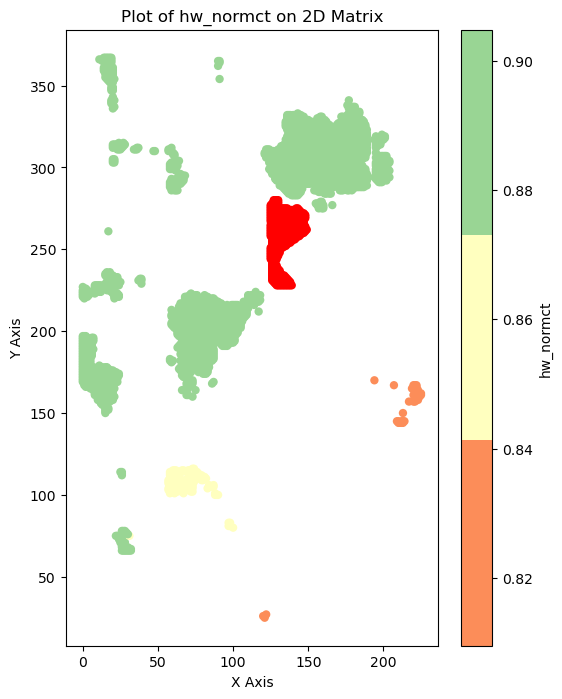

In [10]:
lat_hw = 39.4355565
lon_hw = -122.164115 ## the top wetland point in SacP1Ac1
windex, y_hw, x_hw = close_point(lat_hw, lon_hw)
wind = close_point_wet(lat_hw, lon_hw, wu)
print('wind is:')
print(wind)
print('windex is:')
print(windex)
print('check the inclusivity of this point!!!')
print(inclusion[int(windex)])

rg = np.where(targ[wind] != -1 ) ## only left the ones are not -1

indices = np.array(targ[wind]).astype(int)

hw_outlat = lat_1d[indices][rg]
hw_outlon = lon_1d[indices][rg] ## randomly pick pixel #0. 
hw_normct = normct[int(wind)][rg]
hw_coh = pt1d[indices][rg]

indicesfilt = indices[rg]
xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in indicesfilt]
x_values = [pair[0] for pair in xy_pairs]
y_values = [pair[1] for pair in xy_pairs]

%matplotlib inline

transformed_y_values = [yrg - y for y in y_values]

# Plot the scatter plot with transformed coordinates
colors = ['#fc8d59', '#ffffbf', '#99d594']

# Create a ListedColormap
cmap_custom = ListedColormap(colors)
cmap_custom = ListedColormap(colors)
# Plot the matrix using imshow with custom colormap
plt.figure(figsize=(6, 8))  # Set the figure size

plt.scatter(x_values, transformed_y_values, c=hw_normct, cmap=cmap_custom, edgecolors='none', zorder = 2)
# Add a color bar for reference
plt.colorbar(label='hw_normct')


rg = np.where(inclusion == wu + 1)
xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in rg]
wux = [pair[0] for pair in xy_pairs]
wuy = [pair[1] for pair in xy_pairs]
trans_y = [yrg - y for y in wuy]
plt.scatter(wux, trans_y, color='red', edgecolors='none', zorder = 2)

# Add labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Plot of hw_normct on 2D Matrix')

# Show plot
plt.show()

Step 4a

Using the normct information for all wetland pixels for intersection to get reference candidates that are connected to all wetland pixels

Indices of the selected reference points were stored in variable "top".

This step takes ~5 minutes.

In [13]:
t = wu + 1 ## just for one wetland of interest
ct = 0
tops = radius * radius  ## Select the top 30 reference points for each wetland pixel 
top = np.zeros(tops) ## initialize the top list - ONLY FOR ONE WETLAND UNIT. 
for i in range(yrg):
    print(i)
    for j in range(xrg):

        ind = xrg * i + j
        if inclusion[ind] == t: ## only continue the analysis if the point belongs to this shapefile
            comb = zip(normct[ct], targ[ct])
            srt = sorted(comb, key=lambda k: (-k[0], k[1]))
            temp = [tple[1] for tple in srt] ## only for the reference pixels, second column
            temp = np.array(temp) ## very important step!

            normtmp = [tple[0] for tple in srt] ## the first column
            normtmp = np.array(normtmp)
            goodref = np.where(normtmp > normct_thd)[0] ## thresholding based on normalized connections between the two points
            temp = temp[goodref] ## the filter based on normalized count. 

            if (len(goodref) < wetthd):
                continue

            if (ct == 0): 
                top[0:len(temp)] = temp      
            else:
                tmp = np.intersect1d(top, temp) ## gradually reduce the candiates
                top[0:len(tmp)] = tmp
                top[len(tmp):] = 0 ## remove the rest of items # do not use -1, use :]

            ct = ct + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

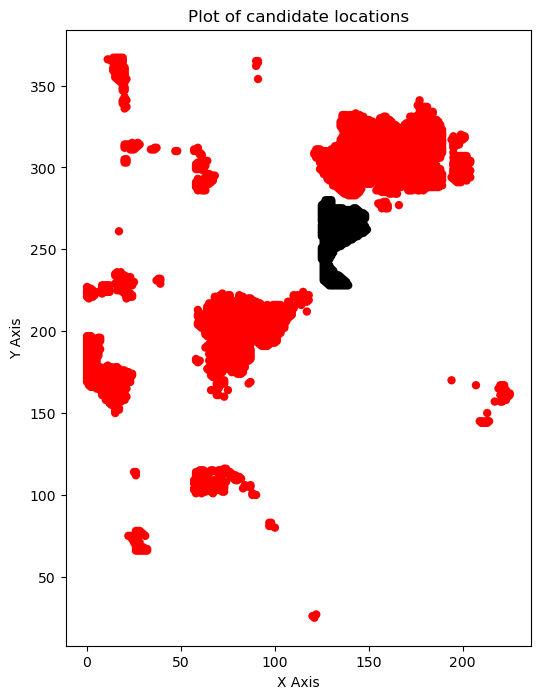

In [14]:
############## Plot results for Step 4a #########

%matplotlib inline
tmp = top
tmp = [x for x in tmp if x != 0]
xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in tmp]
candx = [pair[0] for pair in xy_pairs]
candy = [pair[1] for pair in xy_pairs]

transformed_candy = [yrg - y for y in candy]

# Plot the scatter plot with transformed coordinates
plt.figure(figsize=(6, 8))  # Set the figure size
plt.scatter(candx, transformed_candy, color='r', edgecolors='none')
# Add a color bar for reference

rg = np.where(inclusion == wu + 1)
xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in rg]
wux = [pair[0] for pair in xy_pairs]
wuy = [pair[1] for pair in xy_pairs]
trans_y = [yrg - y for y in wuy]
plt.scatter(wux, trans_y, color='black', edgecolors='none', zorder = 2)

# Add labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Plot of candidate locations')

# Show plot
plt.show()

Step 4b

Select pixels from each of the connected component based on Step 4a. 

In [66]:
############### Step 4b #########################
ycc = np.array(candy).astype(int)
xcc = np.array(candx).astype(int)
bi_image = np.zeros((yrg, xrg))
bi_image[ycc, xcc] = 1
bi_image = bi_image.astype(int)
label_cc, num_features = label_conn_comp(bi_image, min_area, 0, False)
label_1d = np.zeros(xrg * yrg)
ct = 0
for i in range(yrg):
    for j in range(xrg):

        label_1d[ct] = label_cc[i, j]
        ct = ct + 1

latout = np.zeros(len(np.where(inclusion == wu + 1)[0]))
lonout = np.zeros(len(np.where(inclusion == wu + 1)[0]))
ct = 0

for i in range(yrg):
    for j in range(xrg):

        ind = xrg * i + j
        if inclusion[ind] == wu + 1: ## just for SacP1Ac1 
            latout[ct] = lat_1d[ind]
            lonout[ct] = lon_1d[ind]
            ct = ct + 1

cwetla = np.mean(latout)
cwetlo = np.mean(lonout)
cwet = (cwetla, cwetlo)
top_px_lat = np.zeros((pxpercomp, num_features))
top_px_lon = np.zeros((pxpercomp, num_features))
index_px = np.zeros((pxpercomp, num_features))
dist_px = np.zeros((pxpercomp, num_features)) ## recording distance.
coh_px = np.zeros((pxpercomp, num_features)) ## recording distance.


for i in range(1, num_features + 1): ## +1 because in total there are num_features + 1 features (including the background)
    rg = np.where(label_1d == i)[0]
    rglen = len(np.where(label_1d == i)[0])
    coordinates = list(enumerate(zip(lat_1d[rg], lon_1d[rg]))) 
    cohlist = coh_1d[rg] ## coh_1d for those points, pt1d cannot distinguish the candidate points
    distances = [(index, coord, cohlist, eulid_dist(cwetla, cwetlo, coord[0], coord[1])) for index, coord in coordinates]
    # Sort distances in ascending order
    sorted_distances = sorted(distances, key=lambda x: x[3])
    sorted_indices = sorted(range(len(distances)), key=lambda k: distances[k][3])

    coord_res = [coord for index, coord, cohlist, distance  in sorted_distances]
    disttemp = [distance for index, coord, cohlist, distance  in sorted_distances]
    #cohtemp = [cohlist for index, coord, cohlist, distance in sorted_distances]
    cohtemp = [cohlist[i] for i in sorted_indices]

    #index_res = [index for index, coord, distance in sorted_distances]
    index_res = [rg[i] for i in sorted_indices] ## sorted rg. 
    index_res = np.array(index_res).astype(int)

    # Get the top 5 coordinates with the shortest distances
    top_coords = coord_res[:pxpercomp]
    top_px_lat[:, i - 1] = [coord[0] for coord in top_coords]
    top_px_lon[:, i - 1] = [coord[1] for coord in top_coords] ## minus 1 because 0 is the background.
    index_px[:, i - 1] = index_res[:pxpercomp]
    dist_px[:, i - 1] = disttemp[:pxpercomp]
    coh_px[:, i - 1] = cohtemp[:pxpercomp]

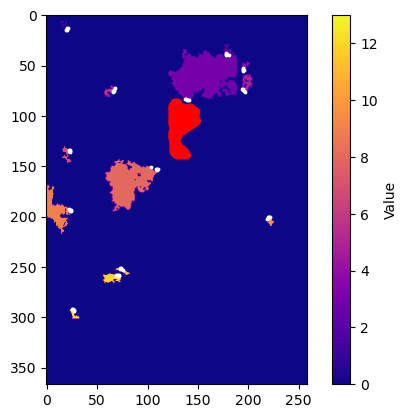

In [67]:
#################### Plot Step 4b ###############
flatind = index_px.flatten()
flatind = flatind.astype(int)
flatind
xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in flatind]
topx = [pair[0] for pair in xy_pairs]
topy = [pair[1] for pair in xy_pairs]

plt.imshow(label_cc, cmap='plasma')

# Add color bar for reference
plt.colorbar(label='Value')


plt.scatter(topx, topy, color='white', marker='o', s = 3)

plt.scatter(wux, wuy, color='red', edgecolors='none', zorder = 2)
# Show plot
plt.show()


Step 5 Selection of reference points using a coherent path

In [68]:
########### Step 5 - final step on selecting ref points #########

clpt = np.zeros(flatind.shape[0]) ## the closes point to each of the top candidate
lalo = np.zeros((wetnum, 2))
wetind = 0 ## used a index for recording the wetland pixels. 
wetloc = np.zeros(wetnum) ## record the index for each wetland pixel
toplat_flat = top_px_lat.flatten()
toplon_flat = top_px_lon.flatten()

for i in range(yrg):
    for j in range(xrg):
        ind = xrg * i + j

        if(inclusion[ind] == wu + 1): ## a wetland pixel IN THE UNIT OF INTEREST, this is using the wetland unit as inclusion pixel value
            lalo[wetind][0] = lat_1d[ind]
            lalo[wetind][1] = lon_1d[ind]
            wetloc[wetind] = ind
            wetind = wetind + 1
                    
for i in range(clpt.shape[0]):
    clpt[i] = close_point_wet(toplat_flat[i], toplon_flat[i], wu)
      

clpt_ind = wetloc[np.array(clpt).astype(int)]
clpt_ind = np.array(clpt_ind).astype(int)
print("the closest points are {x}".format(x = clpt_ind))  
xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in clpt_ind]
x_cl = [pair[0] for pair in xy_pairs]
y_cl = [pair[1] for pair in xy_pairs]
x_cl = np.array(x_cl).astype(int)
y_cl = np.array(y_cl).astype(int)


#bicoh_2d= binary_image(coh_2d, paththd)
coh_2d = np.round(coh_2d, decimals=2)
bicoh_2d = (coh_2d > paththd).astype(np.uint8)

print("paththd is {x}".format(x = paththd))
xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in wetloc]
wetx = [pair[0] for pair in xy_pairs]
wety = [pair[1] for pair in xy_pairs]


for i in range(wetnum):
    bicoh_2d[int(wety[i]), int(wetx[i])] = 1 ## give wetland connectivity

for i in range(wetnum):
    bicoh_2d = dilate_nb(wetx[i], wety[i], dilation, bicoh_2d)

#bicoh_2d = bicoh_2d.astype(int)
label_bicoh, num = label_conn_comp(bicoh_2d, bicoh_min_area, 0, False) 

connectivity = np.zeros(flatind.shape[0])

for i in range(flatind.shape[0]):
    if (label_bicoh[topy[i], topx[i]] == label_bicoh[y_cl[i], x_cl[i]]):
        connectivity[i] = 1
    else:
        connectivity[i] = 0

print("connectivity of all candidiates are:")
print(connectivity)



the closest points are [22660 23971 23964 25012 25012 23435 31982 35610 35350 36140 36130 36130
 36130 22660 23971 23970 25012 25012 23435 31982 35350 35350 36140 36130
 36130 36130 22660 23971 23970 25012 25012 23435 31982 35350 35350 36140
 36130 36130 36130 22660 23971 22663 25012 25012 23435 31982 35610 35350
 36140 36130 36130 36130 22660 23971 22663 25012 25012 23435 31982 35350
 35350 36140 36130 36130 36130]
paththd is 0.9
connectivity of all candidiates are:
[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


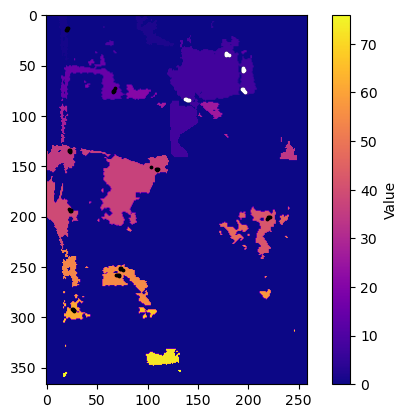

In [69]:
%matplotlib inline
connectivity = connectivity.astype(int)
# Find indices where connectivity is 1
indices = np.where(connectivity == 1)[0]
topx = np.array(topx)
topy = np.array(topy)
# Use these indices to index into topx
plt.clf()
plt.imshow(label_bicoh, cmap='plasma')

# Add color bar for reference
plt.colorbar(label='Value')

plt.scatter(topx, topy, color='black', marker='o', s = 3)

plt.scatter(topx[indices], topy[indices], color='white', marker='o', s = 3)

# Show plot
plt.show()


Visualize the final selected reference point

In [70]:
########## Show the reference point location #####

index_flat = index_px.flatten()
index_flat = np.array(index_flat).astype(int)
dist_flat = dist_px.flatten()
dist_flat = np.array(dist_flat)
coh_flat = coh_px.flatten()
coh_flat = np.array(coh_flat)

# Find the indices where connectivity is equal to 1
indices_connectivity_1 = np.where(connectivity == 1)[0]

# Subset dist_flat and connectivity based on the indices with connectivity equal to 1
dist_px_subset = dist_flat[indices_connectivity_1]
connectivity_subset = connectivity[indices_connectivity_1]
index_subset = index_flat[indices_connectivity_1]

comb = zip(dist_px_subset, connectivity_subset, index_subset)
srt = sorted(comb, key=lambda k: (k[0])) ## use distance ascending order

srt[0][2]


21895

The lat and lon of the selected reference point:

In [72]:
lat_1d[21895]

39.437185

In [73]:
lon_1d[21895]

-122.16033499999999

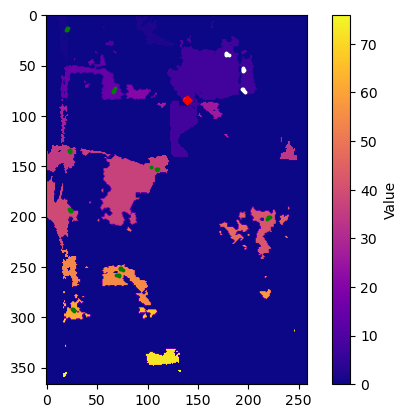

In [74]:
## xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in flatind]

refx = srt[0][2] % xrg
refy = (srt[0][2] - srt[0][2] % xrg) // xrg

connectivity = connectivity.astype(int)
# Find indices where connectivity is 1
indices = np.where(connectivity == 1)[0]
topx = np.array(topx)
topy = np.array(topy)
# Use these indices to index into topx

plt.imshow(label_bicoh, cmap='plasma')

# Add color bar for reference
plt.colorbar(label='Value')

plt.scatter(topx, topy, color='green', marker='o', s = 3)

plt.scatter(topx[indices], topy[indices], color='white', marker='o', s = 3)
plt.scatter(refx, refy, color='red', marker='D', s = 20)
# Show plot
plt.show()


Part 2 Used the selected reference point for InSAR SBAS

Note that you need to change the "directory" variable as below

For your MintPy configuration file, make changes 

Modify_Network:
mintpy.network.tempBaseMax     = 25 #[1-inf, no], auto for no, max temporal baseline in days

mintpy.network.startDate       = 20170518  #[20090101 / no], auto for no

mintpy.network.endDate         = 20170903  #[20110101 / no], auto for no


Reference_Point:

mintpy.reference.lalo =39.437185, -122.160335 ## new dist



Note:
wdts_p1ac1.csv stores the ground reference water level values for wetland unit 4. 

In [27]:
folder = 'Results/Multi/'
wucmd = str(wu)

directory = '/Users/boyazhang/Documents/Work/California/Processing/SacFull/'

# Change directory to the target directory
os.chdir(directory)

cmd1 = "smallbaselineApp.py ./Config/Multi/try_"

cmd2 = ".cfg --dostep "
step1 = "modify_network"
step2 = "rm maskConnComp.h5"
step3 = "generate_mask.py  inputs/ifgramStack.h5 --nonzero -o maskConnComp.h5 --update"
step4 = "reference_point"
step5 = "invert_network"
command = cmd1 + wucmd + cmd2 + step1

### Run the first few steps in MintPy SBAS, including modify_network, generate_mask, reference_point, invert_network
### In your configuration file, you need manually change the reference lat and lon as 39.437185, -122.16033499999999
!{command}
!rm maskConnComp.h5
!generate_mask.py  inputs/ifgramStack.h5 --nonzero -o maskConnComp.h5 --update
command = cmd1 + wucmd + cmd2 + step4 
!{command}
command = cmd1 + wucmd + cmd2 + step5 
!{command}

site = wu

start = 9
end = 18
sitename = 'SacP1Ac1'
FID = 4 
wd = pd.read_csv('./wd/wdts_p1ac1.csv')
dates = ['20170518', '20170530', '20170611', '20170623', '20170705', '20170717','20170729', '20170810','20170822', '20170903']

MintPy version 1.5.2.post1, date 2023-08-10
--RUN-at-2024-05-02 10:10:07.589593--
Current directory: /Users/boyazhang/Documents/Work/California/Processing/SacFull
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: try_4
Go to work directory: /Users/boyazhang/Documents/Work/California/Processing/SacFull
read custom template file: /Users/boyazhang/Documents/Work/California/Processing/SacFull/Config/Multi/try_4.cfg
update default template based on input custom template
    mintpy.network.startDate: 20170506 --> 20170518
    mintpy.network.endDate: 20171009 --> 20170903
    mintpy.reference.lalo: 39.438535, -122.182205 --> 39.437185, -122.

update MODIFICATION_TIME in HDF5 dataset "/coherence"
update MODIFICATION_TIME in HDF5 dataset "/connectComponent"
touch coherenceSpatialAvg.txt
Done.

plot_network.py /Users/boyazhang/Documents/Work/California/Processing/SacFull/inputs/ifgramStack.h5 -t /Users/boyazhang/Documents/Work/California/Processing/SacFull/smallbaselineApp.cfg --nodisplay -d coherence -v 0.2 1.0
read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: /Users/boyazhang/Documents/Work/California/Processing/SacFull/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['/Users/boyazhang/Documents/Work/California/Processing/SacFull/inputs/ifgramStack.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 174
number of interferograms: 1023
shift all perp baseline by 47.346778869628906 to zero mean for plotting
--------------------------------------------------
number of int

MintPy version 1.5.2.post1, date 2023-08-10
--RUN-at-2024-05-02 10:10:29.570148--
Current directory: /Users/boyazhang/Documents/Work/California/Processing/SacFull
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: try_4
Go to work directory: /Users/boyazhang/Documents/Work/California/Processing/SacFull
read custom template file: /Users/boyazhang/Documents/Work/California/Processing/SacFull/Config/Multi/try_4.cfg
update default template based on input custom template
No new option value found, skip updating /Users/boyazhang/Documents/Work/California/Processing/SacFull/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read de

number of pixels to invert: 10276 out of 10276 (100.0%)
estimating time-series via WLS pixel-by-pixel ...
skip pixels with zero value in file: avgSpatialCoh.h5
number of pixels to invert: 12111 out of 12111 (100.0%)
estimating time-series via WLS pixel-by-pixel ...
skip pixels with zero value in file: avgSpatialCoh.h5
skip pixels with zero value in file: avgSpatialCoh.h5
number of pixels to invert: 12111 out of 12111 (100.0%)
estimating time-series via WLS pixel-by-pixel ...
[>                        2%                       ] 200/10276 pixels    0s /     1snumber of pixels to invert: 12111 out of 12111 (100.0%)
estimating time-series via WLS pixel-by-pixel ...
number of pixels to invert: 12111 out of 12111 (100.0%)
estimating time-series via WLS pixel-by-pixel ...
number of pixels to invert: 12111 out of 12111 (100.0%)
estimating time-series via WLS pixel-by-pixel ...
number of pixels to invert: 12110 out of 12111 (100.0%)
estimating time-series via WLS pixel-by-pixel ...
number of pi

In [49]:
pwd

'/Users/boyazhang/Documents/Work/California/Processing/SacFull'

In [56]:
period = range(start, end + 1)
ref = 0
wdv = wd.iloc[:, 2].values
wdv = wdv[period]
wdv = wdv - wdv[ref]

tsobj = timeseries('timeseries.h5')


data = tsobj.read(datasetName=dates)
wetpix = np.where(inclusion == 4 + 1)[0]
wetpixn = len(wetpix)

inc_angle = readfile.read('inputs/geometryGeo.h5', datasetName='incidenceAngle')[0]
poic = np.zeros((wetpixn, end - start + 1)) ## for each wetland pixel, a timeseries 
error = np.zeros(wetpixn) ## calculate the rmse for each wetland pixel

for i in range(wetpixn):
    xi = wetpix[i] % xrg
    yi = int((wetpix[i]  - xi) / xrg)
    #xy_pairs = [(index % xrg, (index - index % xrg) // xrg) for index in flatind]
    
    angle = inc_angle[yi, xi]
    angle = angle / 180 * np.pi 
    poi = data[:, yi, xi]
    poic[i, :] = poi / np.cos(angle)
    poic[i, :] = poic[i, :] * 100
    poic[i, :] = poic[i, :] - poic[i, ref]
    error[i] = calculate_rmse(wdv, poic[i, :])

min_index = np.where(error == np.min(error))

print('the least rmse is')
print(error[min_index])

pred = poic[int(min_index[0])]

true = wdv
ind = np.arange(0, len(pred), 1)  
dates_num = [int(num) for num in dates]
out = np.vstack((ind, dates_num, pred, true))
out = out.transpose()
with open('./'  + folder + 'site ' + str(wu) + '.csv',"w") as f:
        np.savetxt(f, out, delimiter=",", header="ID, dates, pred, true", fmt="%f")


################ Output and Save ######################
latout = np.zeros(wetpixn)
lonout = np.zeros(wetpixn)
IDout = range(wetpixn)

for i in range(wetpixn): ## output the lat, lon, and rmse for each wetland pixel!
    lati = lat_1d[wetpix[i]]
    latout[i] = np.round(lati, 4)
    loni = lon_1d[wetpix[i]]
    lonout[i] = np.round(loni, 4)

###### DTM FILTER ####################################
# for i in range(len(dtmname)):
#     if (sitename == dtmname[i]): ## find the matched DTM product
#         dtmfilter = filterpixel(i, sitename, latout, lonout)

# dtmfilter = np.array(dtmfilter, dtype=np.int64)
# dfilt = dtmfilter.flatten()

# IDout = np.array(IDout)
# IDf = IDout[dfilt]    
# latf = latout[dfilt]    
# lonf = lonout[dfilt]  
# errf = error[dfilt]
# wetpixf = wetpix[dfilt]

# meanerr = np.mean(errf)
# stderr = np.std(errf)
# print("mean value is {x}".format(x = meanerr))
# #print("std value is {x}".format(x = stderr))

# with open('./'  + folder + 'hist_' + wucmd + '.csv',"w") as f:
#     np.savetxt(f, np.array([[wu, meanerr, stderr]]), delimiter=",", 
#            fmt="%f")

# out = np.vstack((IDf, latf, lonf, errf, wetpixf))
# out = out.transpose()
# del incl

# #     with open('./'  + folder + 'rmse_' + wucmd + '.csv',"w") as f:
# #         np.savetxt(f, out, delimiter=",", header="id, lat,lon,rmse, index", 
# #                fmt="%f")
# with open('./'  + folder + 'rmse_' + wucmd + '.csv',"w") as f:
#     np.savetxt(f, out, delimiter=",", header="id, lat,lon,rmse, index", 
#            fmt="%f")

reading timeseries data from file: timeseries.h5 ...
the least rmse is
[0.24165858]


/var/folders/xc/0nh5gdkn5sz1hyvvnl87lbc00000gn/T/ipykernel_1890/1238355707.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = poic[int(min_index[0])]


Last step - plot all wetland pixels' results

/var/folders/xc/0nh5gdkn5sz1hyvvnl87lbc00000gn/T/ipykernel_1890/1294583849.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xo = int(wetpix[min_index] % xrg)
/var/folders/xc/0nh5gdkn5sz1hyvvnl87lbc00000gn/T/ipykernel_1890/1294583849.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yo = int((wetpix[min_index]  - xo) / xrg)


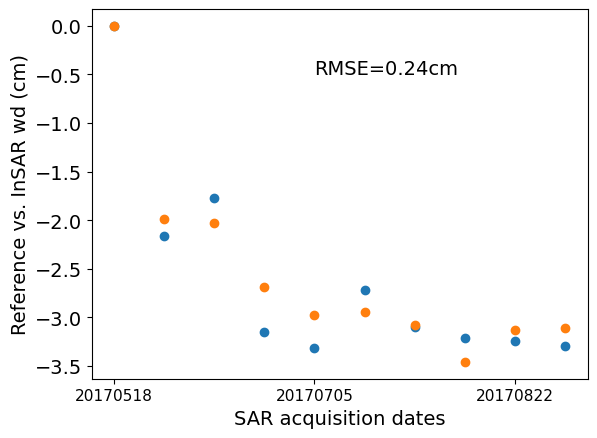

In [63]:
###################### Plot #######################
fs = 14
fig, ax = plt.subplots()
ID = range(end - start + 1)

errmin = np.round(error[min_index], 2)

xo = int(wetpix[min_index] % xrg)
yo = int((wetpix[min_index]  - xo) / xrg)
errmin = errmin.item()

plt.scatter(ID, wdv, label = 'Ground Reference', linestyle='-')
plt.scatter(ID, poic[min_index], label = 'InSAR Predictions', linestyle='-')
plt.xlabel('SAR acquisition dates', fontsize = fs)
plt.ylabel('Reference vs. InSAR wd (cm)', fontsize = fs)
plt.xticks(fontsize=fs-3)
plt.yticks(fontsize=fs)
 
xltick = [dates[i] for i in ID]

if len(ID) > 8:
    ID = ID[::4]
    xltick = xltick[::4]

plt.xticks(ID, xltick)
corr_coeff = np.corrcoef(wdv, poic[min_index])[0, 1]
r2 = corr_coeff * corr_coeff
plt.text(4, -0.5,  r'RMSE=' + f'{errmin:.2f}' +'cm', fontsize=fs, color='black')
plt.show()